In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy


In [112]:
df=pd.read_csv('train.csv/train.csv')

In [113]:
labels=df["label"].values
pixel_data = df.drop('label', axis=1).values
images = pixel_data.reshape(-1, 28, 28)

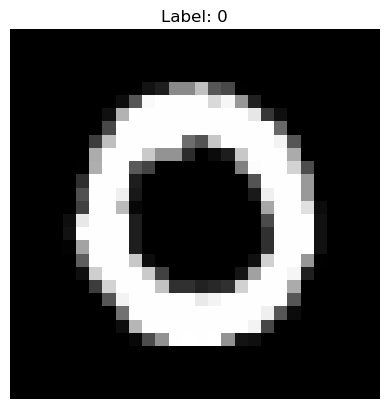

In [114]:
image=images[1]
label=labels[1]
plt.imshow(image,cmap='gray')
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

In [115]:
labels = labels.reshape(42000, 1)
images_flattened = images.reshape(-1, 28 * 28)
data = np.hstack((labels, images_flattened))
np.random.shuffle(data)
split_ratio = 0.8 
num_examples = data.shape[0]
num_train = int(split_ratio * num_examples)
train_set = data[:num_train]
test_set = data[num_train:]
X_train = train_set[:, 1:].T
y_train = train_set[:, 0].T
X_test = test_set[:, 1:].T
y_test = test_set[:, 0].T

In [116]:
print("Training set features shape:", X_train.shape)
print("Training set labels shape:", y_train.shape)
print("Testing set features shape:", X_test.shape)
print("Testing set labels shape:", y_test.shape)

Training set features shape: (784, 33600)
Training set labels shape: (33600,)
Testing set features shape: (784, 8400)
Testing set labels shape: (8400,)


In [117]:
X_train,X_test=X_train/255.0,X_test/255.0
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (784, 33600)
X_test shape: (784, 8400)


In [118]:
y_train_series = pd.Series(y_train)
y_test_series = pd.Series(y_test)

y_train_encoded = pd.get_dummies(y_train_series)
y_test_encoded = pd.get_dummies(y_test_series)

y_train_encoded_np = y_train_encoded.values.T
y_test_encoded_np = y_test_encoded.values.T

print("One-hot encoded y_train shape:", y_train_encoded_np.shape)
print("One-hot encoded y_test shape:", y_test_encoded_np.shape)

One-hot encoded y_train shape: (10, 33600)
One-hot encoded y_test shape: (10, 8400)


In [ ]:
def initialize_parameters(layer_dims):
    np.random.seed(1)   
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        # He initialization for ReLU layers
        parameters['W' + str(l)] = (np.random.randn(layer_dims[l], layer_dims[l-1]) *
                                    np.sqrt(2.0 / layer_dims[l-1]))
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

    return parameters


In [120]:
def initialize_adam(parameters):
    L=len(parameters)//2
    v={}
    s={}
    for l in range(1,L+1):
        v["dW"+str(l)]=np.zeros(parameters["W"+str(l)].shape)
        v["db"+str(l)]=np.zeros(parameters["b"+str(l)].shape)
        s["dW"+str(l)]=np.zeros(parameters["W"+str(l)].shape)
        s["db"+str(l)]=np.zeros(parameters["b"+str(l)].shape)
    return v,s                   

In [121]:
def create_minibatches(X,Y,mini_batch_size,seed):
    np.random.seed(seed)
    m=X.shape[1]
    mini_batches=[]
    permutation=list(np.random.permutation(m))
    shuffled_X=X[:,permutation]
    shuffled_Y=Y[:,permutation].reshape(10,m)

    inc=mini_batch_size

    complete_mini_batches=m//mini_batch_size
    for k in range(0,complete_mini_batches):
        mini_batch_X=shuffled_X[:,k*inc:(k+1)*inc]
        mini_batch_Y=shuffled_Y[:,k*inc:(k+1)*inc]
        mini_batch=(mini_batch_X,mini_batch_Y)
        mini_batches.append(mini_batch)

    if m%mini_batch_size!=0:
        mini_batch_X=shuffled_X[:,complete_mini_batches*inc:m]
        mini_batch_Y=shuffled_Y[:,complete_mini_batches*inc:m]
        mini_batch=(mini_batch_X,mini_batch_Y)
        mini_batches.append(mini_batch)
    return mini_batches    


In [122]:
def relu(Z):
    A=np.maximum(0,Z)
    return A,Z

In [123]:
def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))  # stability trick
    return expZ / np.sum(expZ, axis=0, keepdims=True), Z


In [124]:
def linear_forward(A_prev,W,b):
    Z=np.dot(W,A_prev)+b
    cache=(A_prev,W,b)
    return Z,cache

activation_cache consists of values of Z and linear_cache consists of values A_prev,W,b

In [125]:
def linear_activation_forward(A_prev,W,b,activation,keep_prob=0.8):
    Z,linear_cache=linear_forward(A_prev,W,b)
    if activation=='relu':
        A,activation_cache=relu(Z)
    elif activation=="softmax":
        A,activation_cache=softmax(Z)
    D=None
    if keep_prob<1.0 and activation=='relu':
        D=np.random.rand(*A.shape)<keep_prob
        A=A*D
        A=A/keep_prob
    cache=(linear_cache,activation_cache,D)
    return A,cache

In [126]:
def model_forward(X,parameters):
    caches=[]
    A=X
    L=len(parameters)//2
    for l in range(1,L):
        A_prev=A
        A,cache=linear_activation_forward(A_prev,parameters['W'+str(l)],parameters['b'+str(l)],"relu")
        caches.append(cache)
    AL,cache=linear_activation_forward(A,parameters['W'+str(L)],parameters['b'+str(L)],"softmax")
    caches.append(cache)
    return AL,caches

In [ ]:
def compute_cost(AL, Y,parameters,lambd=1e-4):
    m = Y.shape[1]
    cost = - (1/m) * np.sum(Y * np.log(AL + 1e-8))   
    L=len(parameters)//2
    L2_term=0
    for l in range(1,L+1):
        L2_term+=np.sum(np.square(parameters['W'+str(l)]))
    L2_term=(lambd/(2*m))*L2_term    
    return np.squeeze(cost+L2_term)


In [128]:
def relu_backward(dA,activation_cache):
    Z=activation_cache
    dZ=np.array(dA,copy=True)
    dZ[Z<=0]=0
    return dZ

In [129]:
def linear_backward(dZ,cache,lambd=1e-4):
    A_prev,W,b=cache
    m=A_prev.shape[1]
    dW=(1/m)*np.dot(dZ,A_prev.T)+(lambd/m)*W
    db=(1/m)*np.sum(dZ,axis=1,keepdims=True)
    dA_prev=np.dot(W.T,dZ)
    return dA_prev,dW,db

In [130]:
def linear_activation_backward(dA,cache,AL,Y,activation,keep_prob=0.8):
    linear_cache,activation_cache,D=cache
    if keep_prob<1.0:
        dA=dA*D
        dA=dA/keep_prob
    if activation=="relu":
        dZ=relu_backward(dA,activation_cache)
    dA_prev,dW,db=linear_backward(dZ,linear_cache)
    return dA_prev,dW,db    

In [131]:
def model_backward(AL,Y,caches):
    grads={}
    L=len(caches)
    Y=Y.reshape(AL.shape)
    dZL=AL-Y
    current_cache=caches[L-1]
    dA_prev,dW,db=linear_backward(dZL,current_cache[0])
    grads["dA"+str(L-1)]=dA_prev
    grads["dW"+str(L)]=dW
    grads["db"+str(L)]=db

    for l in reversed(range(L-1)):
        current_cache=caches[l]
        dA_prev,dW,db=linear_activation_backward(grads["dA"+str(l+1)],current_cache,AL,Y,"relu")
        grads["dA"+str(l)]=dA_prev
        grads["dW"+str(l+1)]=dW
        grads["db"+str(l+1)]=db

    return grads    

In [132]:
def update_parameters_with_adam(params,grads,learning_rate,v,s,t,beta1=0.9,beta2=0.999,epsilon=1e-8):

    parameters=copy.deepcopy(params)
    L=len(parameters)//2 # number of layers
    v_corrected={}
    s_corrected={}
    for l in range(1,L+1):       # as W is a matrix which contains all the weights for a particular layer and W1,W2,... represents W matrix for a particular layer, here for layer [1] and layer [2].
        v["dW" + str(l)] = beta1 * v["dW" + str(l)] + (1 - beta1) * grads["dW" + str(l)]
        v["db" + str(l)] = beta1 * v["db" + str(l)] + (1 - beta1) * grads["db" + str(l)]
        v_corrected["dW" + str(l)] = v["dW" + str(l)] / (1 - beta1 ** t)
        v_corrected["db" + str(l)] = v["db" + str(l)] / (1 - beta1 ** t)
        s["dW" + str(l)] = beta2 * s["dW" + str(l)] + (1 - beta2) * (grads["dW" + str(l)] ** 2)
        s["db" + str(l)] = beta2 * s["db" + str(l)] + (1 - beta2) * (grads["db" + str(l)] ** 2)
        s_corrected["dW" + str(l)] = s["dW" + str(l)] / (1 - beta2 ** t)
        s_corrected["db" + str(l)] = s["db" + str(l)] / (1 - beta2 ** t)
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * v_corrected["dW" + str(l)] / (np.sqrt(s_corrected["dW" + str(l)]) + epsilon)
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * v_corrected["db" + str(l)] / (np.sqrt(s_corrected["db" + str(l)]) + epsilon)

    return parameters,v,s
    

In [135]:
def model(X,Y,layer_dims,learning_rate,num_epochs,mini_batch_size,print_cost):
    costs=[]
    parameters=initialize_parameters(layer_dims)
    v,s=initialize_adam(parameters)
    t=0
    m=X.shape[1]
    for epoch in range(num_epochs):
        mini_batches=create_minibatches(X,Y,mini_batch_size,seed=epoch)
        for minibatch in mini_batches:
            (minibatch_X,minibatch_Y)=minibatch
            AL,caches=model_forward(minibatch_X,parameters)
            cost=compute_cost(AL,minibatch_Y,parameters)
            grads=model_backward(AL,minibatch_Y,caches)
            t+=1
            parameters,v,s=update_parameters_with_adam(parameters,grads,learning_rate,v,s,t)

        if print_cost and (epoch%1==0):
            print(f"Cost after epoch {epoch}: {np.squeeze(cost)}")
            costs.append(cost)
    return parameters,costs    

In [136]:
layers_dims = [784, 256, 128, 64, 10]

parameters,costs=model(X_train,y_train_encoded_np,layers_dims,learning_rate=0.001,num_epochs=20,mini_batch_size=128,print_cost=True)

Cost after epoch 0: 0.23641815975355512
Cost after epoch 1: 0.2089385214742737
Cost after epoch 2: 0.02989700505039775
Cost after epoch 3: 0.1465833353275288
Cost after epoch 4: 0.19034635222434435
Cost after epoch 5: 0.024800839464125986
Cost after epoch 6: 0.10125714387900851
Cost after epoch 7: 0.009159161048578427
Cost after epoch 8: 0.017914389857110913
Cost after epoch 9: 0.01264776126629726
Cost after epoch 10: 0.11417823504108415
Cost after epoch 11: 0.1735268296586493
Cost after epoch 12: 0.02590538456976806
Cost after epoch 13: 0.00624702125636072
Cost after epoch 14: 0.002431094938804476
Cost after epoch 15: 0.0037100725397123642
Cost after epoch 16: 0.0223173951357667
Cost after epoch 17: 0.01916323739805978
Cost after epoch 18: 0.013357906175175382
Cost after epoch 19: 0.05488708225294749


In [ ]:
def predict(X, parameters, Y=None):
    AL, _ = model_forward(X, parameters)   # AL shape = (n_y, m)
    
    predictions = np.argmax(AL, axis=0)    # shape = (m,)
    
    if Y is not None:
        true_labels = np.argmax(Y, axis=0)   
        accuracy = np.mean(predictions == true_labels) * 100
        return predictions, accuracy
    else:
        return predictions
predictions, accuracy = predict(X_train, parameters, y_train_encoded_np)
print(f"Train set accuracy: {accuracy:.2f}%")
predictions, accuracy = predict(X_test, parameters, y_test_encoded_np)
print(f"Test set accuracy: {accuracy:.2f}%")

Train set accuracy: 99.02%
Test set accuracy: 96.95%


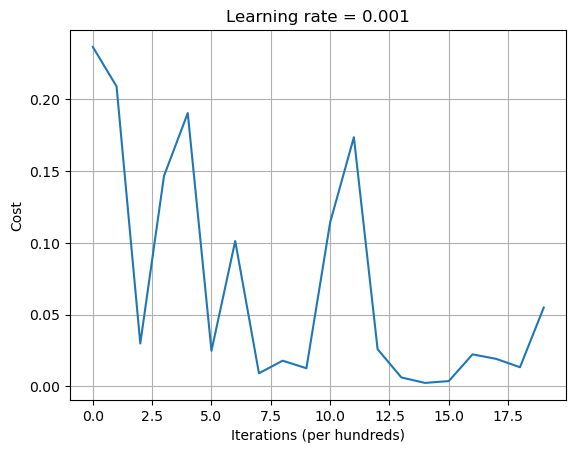

In [138]:
def plot_costs(costs, learning_rate):
    """
    Plot the learning curve (cost vs iterations).
    
    Arguments:
    costs -- list of costs recorded during training
    learning_rate -- learning rate used (for labeling the plot)
    """
    plt.plot(costs)
    plt.ylabel('Cost')
    plt.xlabel('Iterations (per hundreds)')
    plt.title(f'Learning rate = {learning_rate}')
    plt.grid(True)
    plt.show()
plot_costs(costs, learning_rate=0.001)